<a target="_blank"  href="https://www.birmingham.ac.uk/schools/chemical-engineering/index.aspx"><img src="https://intranet.birmingham.ac.uk/staff/images/brand/download/jpg/crested-wm-full-colour.jpg" style="height:200px; display: block; margin-left: auto; margin-right: auto;"/></a>


# **Interactive Example:** Autonomously Calibrating DEM Simulations using ACCES
#### Matching experimental GranuTools GranuDrum measurements using a DEM digital twin

---

#### Copyright 2023 The Coexist Developers.
##### Notebook authored by Andrei Leonard Nicusan.

Licensed under the GNU License, Version 3.0.

## **What**: Discovering the microscopic DEM parameters that reproduce a bulk measurement 

As the discrete element method is essentially a numerical approximation of the ensemble dynamics of granular materials, it (still) has some particle contact parameters that must be calibrated. In other words, depending on the contact parameters used, DEM is capable of reproducing the bulk dynamics of large / small, free-flowing / cohesive, frictional / collisional systems; the parameters most often calibrated are:

- Sliding friction $\mu_s$.
- Rolling friction $\mu_r$.
- Coefficient of restitution $\epsilon$.
- Cohesion (depending on the contact model used - the most common one is currently a form of Johnson-Kendall-Roberts).

Depending on the system, the bulk volume might be calibrated along with the frictional parameters above - that is, the number of particles (required by DEM) in a given bulk volume (required by characterisation instruments).

DEM digital twins of powder characterisation equipment are often used to calibrate these parameters - the question we're asking is **"What microscopic particle properties reproduce an experimental bulk measurement?"**; let's take a GranuTools GranuDrum as an example:

![GranuDrum Digital Twin](https://coexist.readthedocs.io/en/latest/_images/cost_function.png)

## **How**: Calibration == Optimisation

Calibration can be framed as an optimisation problem: *what parameter values minimise the difference between my simulation and experiment*? We can use any sensible measurable quantity as an objective to minimise: 

- The difference between the simulated angle of repose and a measurement.
- The yield curve of a shear cell digital twin.
- The velocity vector field within a pilot-scale mixer.
- The residence time distribution of a twin-screw feeder.

In the previous tutorial, `LIGGGHTS-Basics` we introduced a DEM digital twin of a GranuTools GranuDrum - it would be easy to change some parameters, run it again, run the post-processing code and repeat; easy, but tedious and with no guarantee we'd find the true, physical parameters. This is the part that ACCES automates.


### Pre-requisites

To run the ACCES calibration in this notebook, we'll need to install some packages via `pip`, Python's helpful package manager:

In [ ]:
# Install Python libraries (LIGGGHTS can be installed separately; on BinderHub it is pre-installed)
!pip install konigcell opencv-python pyvista coexist

## What do I need to change in my simulation?

Not much. If you already have a working simulation, we just need to be able to launch it from Python with some parameter values - then ACCES can modify / evolve those for us - like this:

```shell
parameter1 = ...
parameter2 = ...
...

generate trial simulation with parameters
run trial simulation                        # Done already
post-process trial simulation               # Done already
```

The `Template` directory contains the GranuTools GranuDrum digital twin (`granudrum.sim`); we can make a copy of it in `TrialSimulations` and modify some parameters we want to calibrate - run the next Python cell:

In [1]:
# Utilities for copying directories
import shutil

# Give this trial an ID and a corresponding subdirectory within TrialSimulations
trial_id = 0
trial_directory = "TrialSimulations/sim" + str(trial_id)

# Copy the GranuDrum simulation template to its own trial
shutil.copytree("Template", trial_directory, dirs_exist_ok = True)

# Now let's change the trial parameters
rpm = 45
num_particles = 30_000
sliding = 0.5
rolling = 0.5

# Read the GranuDrum LIGGGHTS script commands into a list of strings, one for each line of text
with open(trial_directory + "/granudrum.sim") as f:
    script = f.readlines()

# Change the lines defining the trial parameters to our modified values
script[12] = f"variable RotationPeriod equal 60/{rpm}\n"
script[13] = f"variable NumParticles equal {int(num_particles)}\n"
script[22] = f"variable SlidingPP equal {sliding}\n"
script[23] = f"variable SlidingPW equal {sliding}\n"
script[25] = f"variable RollingPP equal {rolling}\n"
script[26] = f"variable RollingPW equal {rolling}\n"

# Save the modified script back into the trial subdirectory
with open(trial_directory + "/granudrum.sim", "w") as f:
    f.writelines(script)

That is the setup code; you can change the parameters `rpm`, `num_particles`, `sliding` and `rolling` and rerun the code cell - a new trial will be generated. Now we could run this trial from Python (one simulation will take about 50 minutes; you can skip this part):

In [2]:
import subprocess

# Launch a subprocess running LIGGGHTS in the given trial_directory
proc = subprocess.Popen(
    ["liggghts", "-in", "granudrum.sim"],
    cwd = trial_directory,          # Change current working directory
)

# Wait for simulation to finish...
# proc.wait()

# ... or stop process
proc.kill()

## Calibration and Validation of multiple objectives

An important finding of the IFPRI Round-Robin project is the need for "N-parameters, N-outputs" when calibrating; the GranuDrum free surface shape is particularly sensitive in this regard:

![ACCES Multiple Calibration](https://github.com/uob-positron-imaging-centre/ACCES-CoExSiST/blob/master/docs/source/_static/access_multi_calibrate.png?raw=true)

The `run_simulation_trial.py` launches two GranuDrum simulations per trial - one at 15 RPM and one at 45 RPM - we will ask ACCES to calibrate both simultaneously. This is a particularly robust combination, as **the two simulations are in different flow states**:

- At 15 RPM it is in the *rolling* regime.
- At 45 RPM it is in the *cascading* regime.

**A calibrated set of parameters will reproduce both.**

We could run a single trial for the median parameter values (it would take about 50 minutes; you can skip this as we've included its results in this notebook already):

In [ ]:
%run run_simulation_trial.py

---
And we can plot the simulated free surfaces:

Trial simulation ID 0:
For RPM = 15, error to experiment = 82.14506539833533 mm2


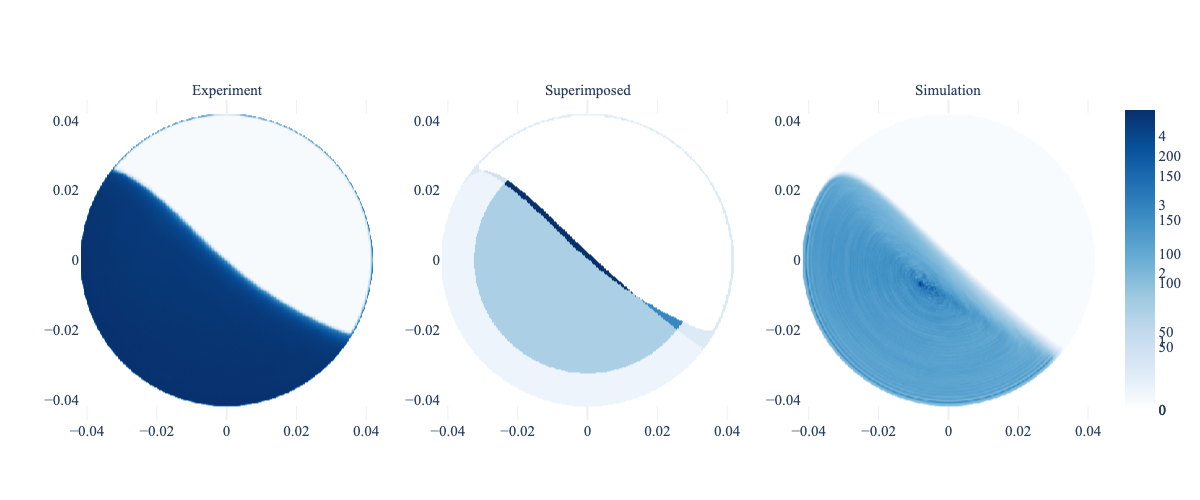

For RPM = 45, error to experiment = 183.21046373365047 mm2


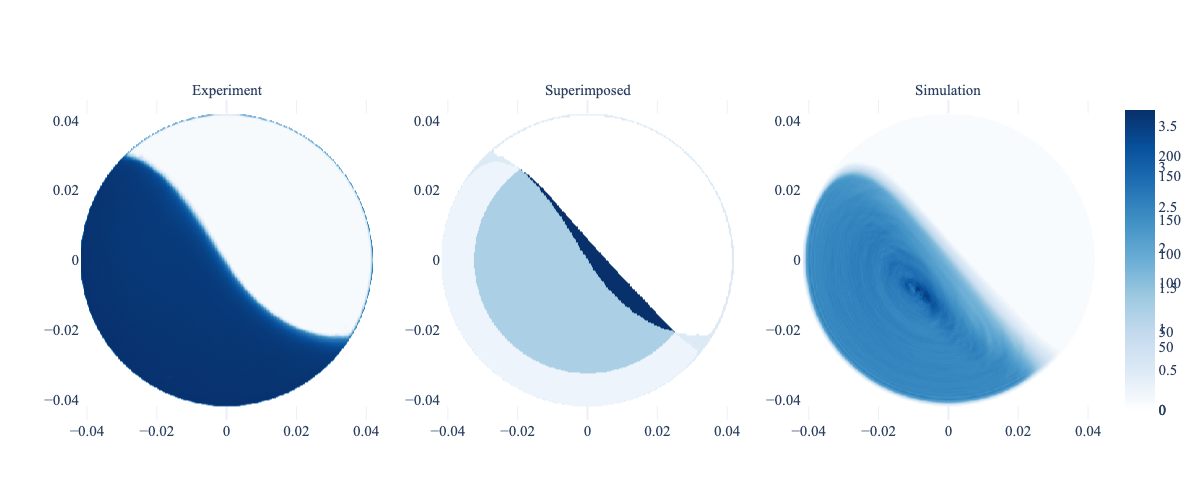

In [3]:
# Set plots' renderer - e.g. "iframe", "browser", "pdf", "png"
import plotly
plotly.io.renderers.default = "png"

print("Trial simulation ID 0:")
%run postprocess_simulation_trial.py 0

## Letting ACCES evolve parameters for us!

There's one final step to automate the calibration problem - telling ACCES what parameters it can evolve and what error to minimise:

In [4]:
# ACCES PARAMETERS START
import coexist

parameters = coexist.create_parameters(
    ["sliding", "rolling", "num_particles"],
    minimums = [0.0, 0.0, 20_000],
    maximums = [1.0, 1.0, 40_000],
)
access_id = 0              # The trial ID
# ACCES PARAMETERS END

sliding = parameters["value"]["sliding"]
rolling = parameters["value"]["rolling"]
num_particles = int(parameters["value"]["num_particles"])

# ... Generate simulation
# ... Run simulation
# ... Post-process

error = ...

That's it! The complete script is in the `run_simulation_trial.py` Python file, check it out. Take a moment to appreciate what this single script accomplishes:

- Create a simulation directory for our simulation.
- Generate trial simulation runs on the fly in a different domain-specific script.
- Launches a different program (containing thousands of lines of C++) running that generated script.
- Post-processes simulated results and experimental measurements.
- Computes a quantitative error between simulation and experiment.

Note that this script is completely standalone - you can run it on its own and see it complete an entire simulation trial, doing everything we've outlined above.

Also note that **most DEM practitioners already have such workflows**, albeit often spread out across multiple files that need modification by hand. The ACCES workflow is straightforward to retrofit onto pre-existing simulations - even if they are using multiple programs and programming languages: just launch them from a single script (which you might have even already been doing).

Now what will ACCES do? This diagram explains it:

![ACCES Architecture](https://github.com/uob-positron-imaging-centre/ACCES-CoExSiST/blob/master/docs/source/_static/access_architecture.png?raw=true)

- Take the single trial script and figure out where the `parameters` and `error` are.
- Automatically parallelise it - each simulation trial will be run in parallel, on local machines or distributed supercomputers.
- Run simulation trials and collect the errors.
- Combine multiple objectives and use CMA-ES to generate new simulation trials.

Launching ACCES itself on a local computer is trivial:

In [5]:
# Use ACCES to learn a simulation's parameters
import coexist

# Initialise ACCES with the script running a single trial and let it work its magic
access = coexist.Access("run_simulation_trial.py")
access.learn(
    num_solutions = 8,          # Number of solutions per epoch
    target_sigma = 0.05,        # Target std-dev (accuracy) of solution
    random_seed = 42,           # Reproducible / deterministic optimisation
);


Starting ACCES run at 14:12:09 on 12/06/2023 in directory `access_seed42`.
Found previous ACCES results in `access_seed42/history_pop8_scaled.csv`.

Injected   8 / 240 historical solutions
Injected  16 / 240 historical solutions
Injected  24 / 240 historical solutions
Injected  32 / 240 historical solutions
Injected  40 / 240 historical solutions
Injected  48 / 240 historical solutions
Injected  56 / 240 historical solutions
Injected  64 / 240 historical solutions
Injected  72 / 240 historical solutions
Injected  80 / 240 historical solutions
Injected  88 / 240 historical solutions
Injected  96 / 240 historical solutions
Injected 104 / 240 historical solutions
Injected 112 / 240 historical solutions
Injected 120 / 240 historical solutions
Injected 128 / 240 historical solutions
Injected 136 / 240 historical solutions
Injected 144 / 240 historical solutions
Injected 152 / 240 historical solutions
Injected 160 / 240 historical solutions
Injected 168 / 240 historical solutions
Injected 1

But it finished almost instantly! How?

As simulations are expensive to run - and (super)computers can be unreliable - ACCES takes great care to save all results it has found such that it can always retrace its steps. We've run this particular ACCES calibration already and saved all results in the `access_seed42` directory - when launching ACCES here, it transparently loaded its own history - no need to run new simulations!

## Calibration results

We can load all simulation results from the `access_seed42` directory into a neat structure:

In [6]:
# Read in ACCES results
import coexist

data = coexist.AccessData("access_seed42")
data

AccessData
--------------------------------------------------------------------------------
paths             ╎ AccessPaths(...)
parameters        ╎                       value      min      max       sigma
                  ╎ sliding            0.561347      0.0      1.0    0.022619
                  ╎ rolling            0.293141      0.0      1.0    0.016084
                  ╎ num_particles  29185.017132  20000.0  40000.0  193.503347
parameters_scaled ╎                   value  min  max     sigma
                  ╎ sliding        1.403368  0.0  2.5  0.056548
                  ╎ rolling        0.732853  0.0  2.5  0.040210
                  ╎ num_particles  3.648127  2.5  5.0  0.024188
scaling           ╎ [4.e-01 4.e-01 8.e+03]
population        ╎ 8
num_epochs        ╎ 30
target            ╎ 0.05
seed              ╎ 42
epochs            ╎ DataFrame(sliding_mean, rolling_mean, num_particles_mean,
                  ╎           sliding_std, rolling_std, num_particles_std,
              

We can access the `.results` field directly and select the best simulation - i.e. the one with the smallest combined error in the 15 RPM (`error0`) and 45 RPM (`error1`) cases:

In [7]:
# Print the data.results field
print("Simulation results:\n", data.results, "\n")

# Find best simulation
best_index = data.results["error"].idxmin()
best_result = data.results.loc[best_index]

# Print best result
print("Best result found for simulation trial ID", best_index, ":")
print(best_result)

Simulation results:
       sliding   rolling  num_particles      error0      error1          error
0    0.601572  0.153339   35003.007972  354.007134  420.827586  148975.967854
1    0.813522  0.110345   21319.980592  667.091558  633.231867  422423.632406
2    0.542613  0.394586   29887.992283   75.381688   87.324614    6582.676814
3    0.215652  0.793133   35185.279570  244.680143  261.888228   64078.849068
4    0.522010  0.875747   33116.728948  297.545779  420.485137  125113.577500
..        ...       ...            ...         ...         ...            ...
235  0.555280  0.271385   29362.670622   42.549346   28.166468    1198.464814
236  0.558605  0.299437   29175.867530   47.129608   20.889417     984.510043
237  0.569330  0.277342   29475.077652   36.984542   32.147444    1188.958482
238  0.603741  0.283199   29236.099126   51.538644   30.306778    1561.970238
239  0.587135  0.294026   29274.586591   37.541023   30.649227    1150.603327

[240 rows x 6 columns] 

Best result found

---
We can check the “convergence plot” showing the evolution of the ACCES run using `coexist.plots.access` - this can be done even while 2-weeks long simulations run to check intermediate results:

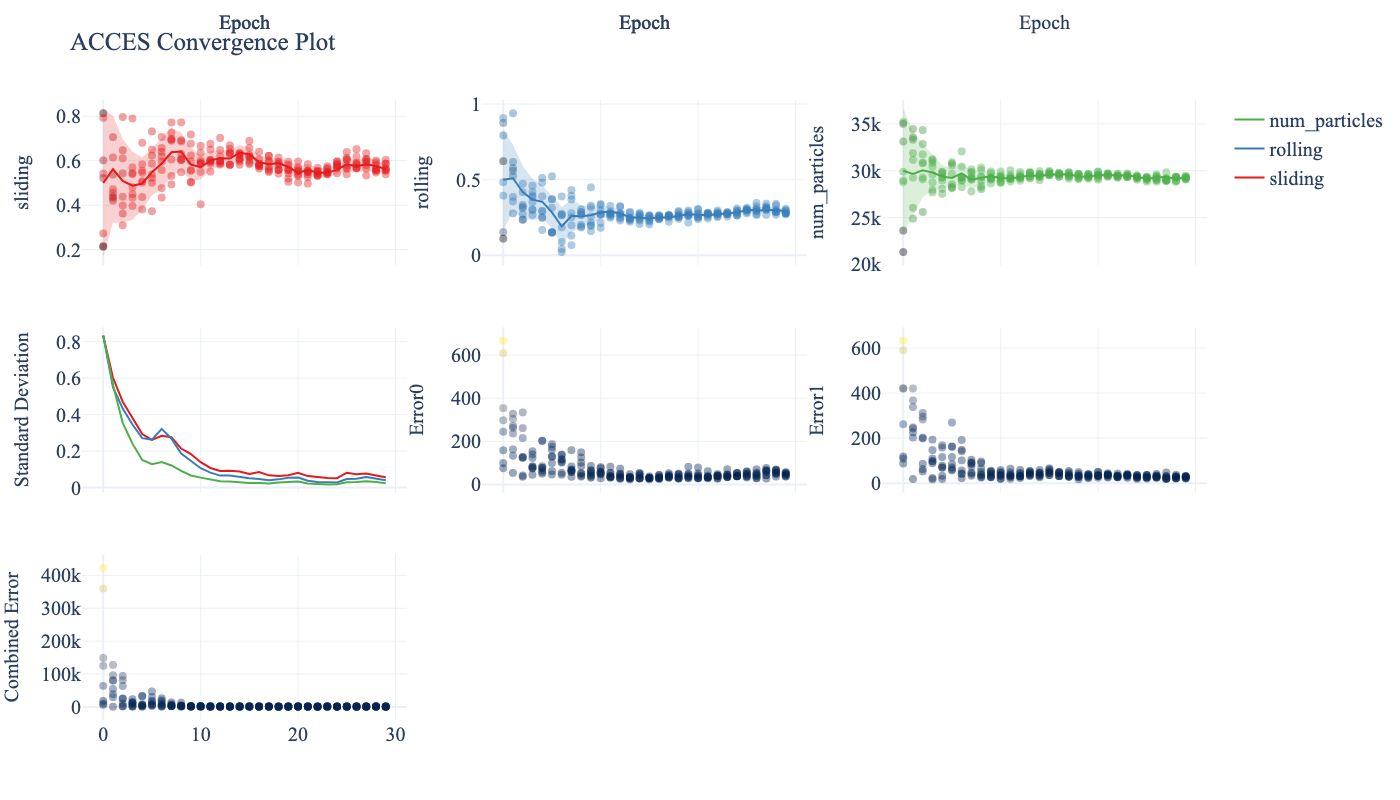

In [8]:
# Set plots' renderer - e.g. "iframe", "browser", "pdf", "png"
import plotly
plotly.io.renderers.default = "png"

coexist.plots.access("access_seed42").show(width=1400, height=800)

The x-axis represents the optimisation epochs, while the dots show the values used in the simulation trials. Notice the quick convergence onto the optimum parameter values -

The `Standard Deviation` plot shows the uncertainty associated with each parameter - the fastest parameter to converge is the `num_particles`, which naturally has a strong effect on the error values, while the `sliding` and `rolling` follow soon after. Notice the quick convergence onto the optimum parameter values, as the `Combined Error` sharply decreases.

The best simulation trial was the 144th one in epoch 18. With each simulation trial taking 40-50 minutes on my machine, the calibration can finish on a 16-core computer in about 24 hours! Not bad for solving the micro-macro parameter mapping inverse problem - just setting up a DEM simulation can take far longer.

Finally, we can visualise the error values as 2D "heatmaps" between pairs of free parameters (colour-coded by the error value of the closest simulation trial to each pixel):

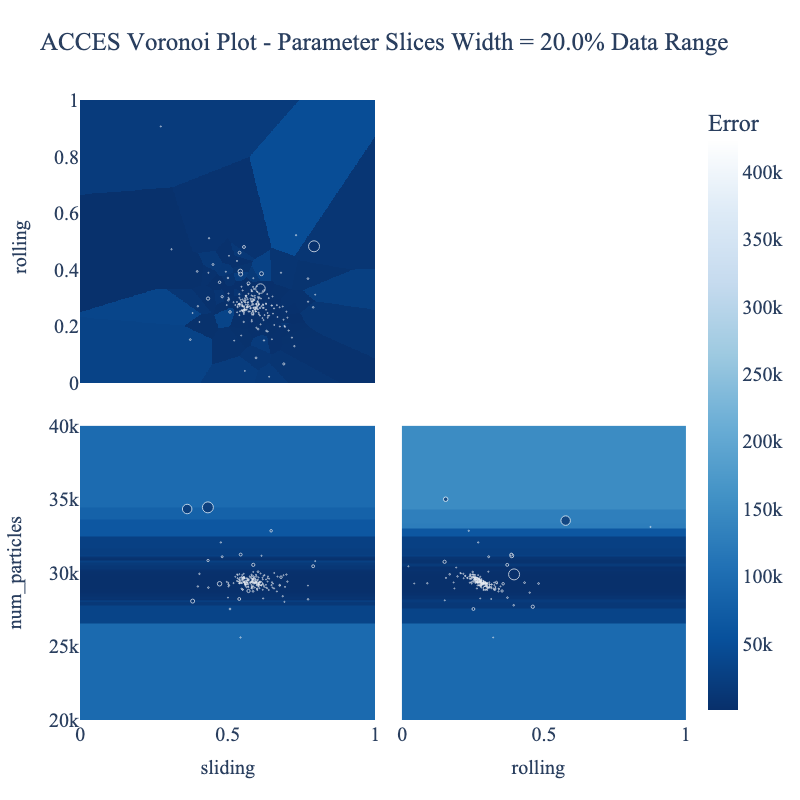

In [9]:
coexist.plots.access2d("access_seed42").show(width=800, height=800)

The dots represent where each simulation trial was run - notice how minimal numbers of simulations were run in high error regions, while we focus on finding the true globally optimum parameters.

## ACCES-Calibrated Simulation

Finally, let's see what the GranuDrum simulations with calibrated parameters look like:

Trial simulation ID 144:
For RPM = 15, error to experiment = 59.28656361474436 mm2


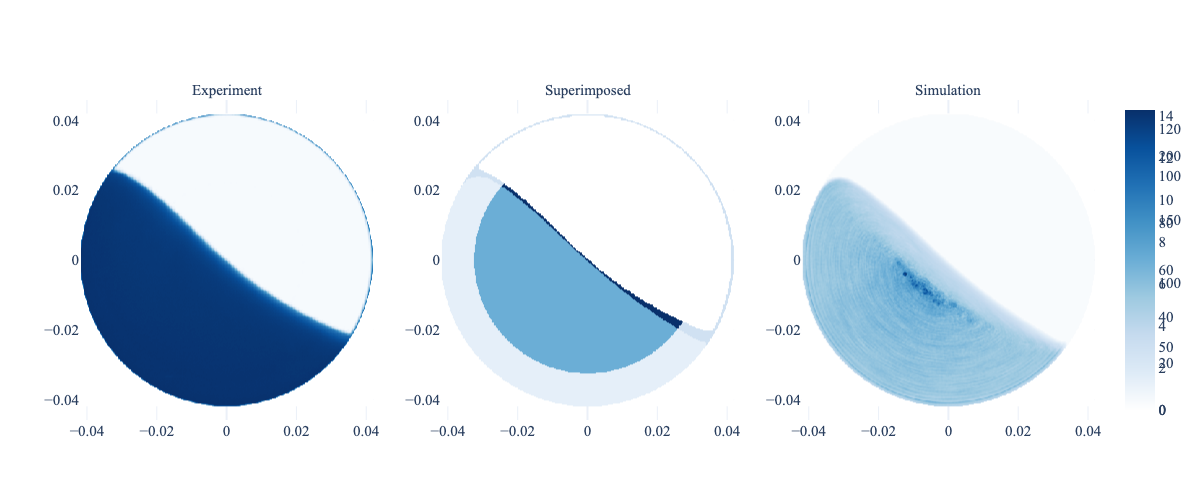

For RPM = 45, error to experiment = 18.834720570749113 mm2


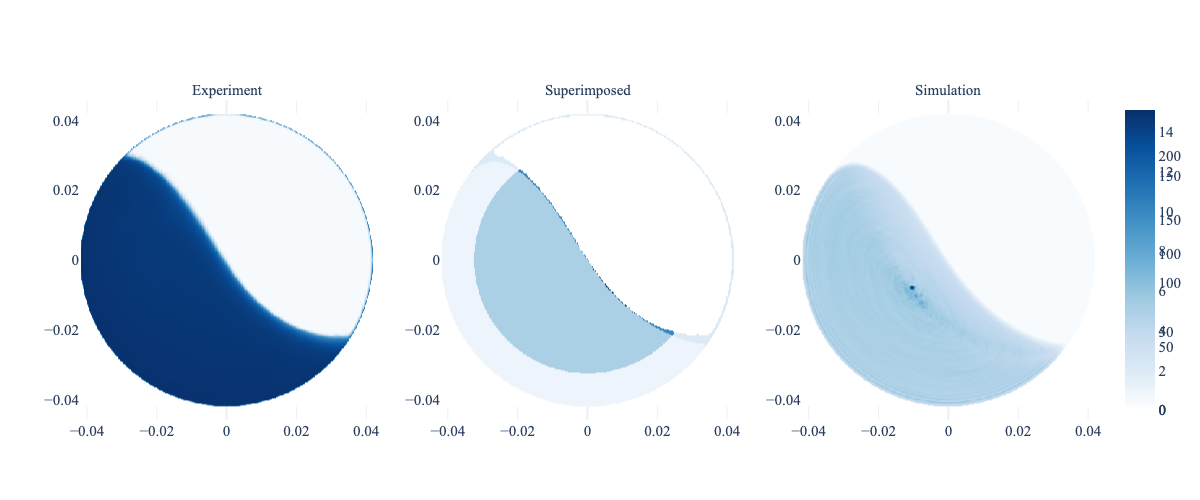

In [10]:
# Set plots' renderer - e.g. "iframe", "browser", "pdf", "png"
import plotly
plotly.io.renderers.default = "png"

print("Trial simulation ID 144:")
%run postprocess_simulation_trial.py 144

The calibrated contact parameters for MCC are representative of the real material - and they are sensibly physical:
- $\mu_s = 0.561$.
- $\mu_r = 0.293$.
- $29,185$ particles in $50$ mL.

## Summary

In this notebook, we have:

- Modified a typical DEM digital twin to be autonomously calibrated by ACCES.
- **Reproduced two different flow regimes in a GranuTools GranuDrum _simultaneously_**.
- Back-computed microscopic contact parameters from a bulk powder measurement.
- Solved calibration as a 3D (global, nasty) optimisation problem with only 240 trials, in under 24 hours.